# Demo of Diffusion Modelling by Gaussian Mixture Model

Author: Binxu Wang (binxu_wang@hms.harvard.edu)

Data: June.19th, 2022

* MLFS Day 1: Score, Diffusion process, Reverse Diffusion
* MLFS Day 2: Score matching, approximating score with Neural Networks.


Let's first choose one **simple yet expressive model** as our toy -- Gaussian mixture in $n$ dim. 

**Simplicity**
* Density and score are analytically tractable and straigtforward to evaluate. 
* Gaussian mixture remains Gaussian mixture under diffusion process. 

**Expressivity**
* As we know, given enough Gaussian bumps you can approximate any distribution. [this post](https://stats.stackexchange.com/questions/446351/the-approximation-power-of-gaussian-mixture-models)
* Moreover, any Gaussian kernel density estimation of a point cloud is a Gaussian Mixture! 
![](https://upload.wikimedia.org/wikipedia/commons/6/61/Synthetic_data_2D_KDE.png)



$$
p(x)=\sum_i^k\pi_i f(x;\mu_i,\Sigma_i)
$$
Let $f$ represent the Density of Multivariate Gaussian in $n$ dim. 
$$
f(x;\mu,\Sigma)=((2\pi)^n\det\Sigma)^{-1/2}\exp(-\frac12(x-\mu)^T\Sigma^{-1}(x-\mu))
$$
The weights $\sum_i\pi_i=1$. 


## Deriving the score analytically
Let's abbreviate $f_i(x):=f(x;\mu_i,\Sigma_i)$ be the Gaussian density of the component $i$
$$
\log p(x)=\log \sum_i\pi_i f_i(x)\\
$$
The score function reads
$$
\nabla_x \log p(x)=\frac{\sum_i\pi_i \nabla_x f_i(x)}{\sum_i\pi_i f_i(x)}\\
=-\frac{\sum_i\pi_i f_i(x)\Sigma_i^{-1}(x-\mu_i)}{\sum_i\pi_i f_i(x)}\\
=\sum_i w_i\nabla \log f_i(x)
$$

It is the weighted average of the gradient of the log density of each gaussian $\nabla \log f_i(x)=-\Sigma_i^{-1}(x-\mu_i)$, weighted by the participation of each component $\pi_i f_i(x)$. 

The weights, $w_i=\frac{\pi_i f_i(x)}{\sum_j\pi_j f_j(x)}=\frac{p(x|z=i)p(z=i)}{p(x)}=p(z=i|x)$.


## Define the Gaussian Mixture model

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
# from numpy.random.mtrand import sample

In [ ]:
class GaussianMixture:
  def __init__(self, mus, covs, weights):
    """
    mus: a list of K 1d np arrays (D,)
    covs: a list of K 2d np arrays (D, D)
    weights: a list or array of K unnormalized non-negative weights, signifying the possibility of sampling from each branch. 
      They will be normalized to sum to 1. If they sum to zero, it will err.
    """
    self.n_component = len(mus)
    self.mus = mus
    self.covs = covs  # covariance 
    self.precs = [np.linalg.inv(cov) for cov in covs]  # precision
    self.weights = np.array(weights)
    self.norm_weights = self.weights / self.weights.sum()
    self.RVs = []
    for i in range(len(mus)):
      self.RVs.append(multivariate_normal(mus[i], covs[i]))
    self.dim = len(mus[0])
  
  def add_component(self, mu, cov, weight=1):
    self.mus.append(mu)
    self.covs.append(cov)
    self.precs.append(np.linalg.inv(cov))
    self.RVs.append(multivariate_normal(mu, cov))
    self.weights.append(weight)
    self.norm_weights = self.weights / self.weights.sum()
    self.n_component += 1
  
  def pdf(self, x):
    """
      probability density (PDF) at $x$. 
    """
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    prob = np.dot(component_pdf, self.norm_weights)
    return prob
  
  def sample(self, N):
    """ Draw N samples from Gaussian mixture
    Procedure:
      Draw N samples from each Gaussian
      Draw N indices, according to the weights. 
      Choose sample between the branches according to the indices. 
    """
    rand_component = np.random.choice(self.n_component, size=N, p=self.norm_weights)
    all_samples = np.array([rv.rvs(N) for rv in self.RVs])
    gmm_samps = all_samples[rand_component, np.arange(N),:]
    return gmm_samps, rand_component, all_samples
  
  def score(self, x):
    """
    Compute the score $\nabla_x \log p(x)$ for $x$ of shape (N, 2)
    """
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    """
    TODO: Finish computing the `participance`
    """
    raise NotImplementedError
    participance = ...

    scores = np.zeros_like(x)
    """
    TODO: Finish computing the `scores`
    """
    ...
    return scores
  
  def score_decompose(self, x):
    """
    Compute the score of each component $\nabla_x \log f_i(x)$ 
    and the participance for $x$ of shape (N, 2)
    """
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    """
    TODO: Finish computing the `participance`
    """
    raise NotImplementedError
    participance = ...

    gradvec_list = []
    for i in range(self.n_component):
      """
      TODO: Finish computing the `gradvec`
      """
      gradvec = ...
      gradvec_list.append(gradvec)
    
    return gradvec_list, participance



def quiver_plot(pnts, vecs, *args, **kwargs):
  plt.quiver(pnts[:, 0], pnts[:,1], vecs[:, 0], vecs[:, 1], *args, **kwargs)

In [ ]:
def kdeplot(pnts, label="", ax=None, titlestr=None, **kwargs):
  if ax is None:
    ax = plt.gca()#figh, axs = plt.subplots(1,1,figsize=[6.5, 6])
  sns.kdeplot(x=pnts[:,0], y=pnts[:,1], ax=ax, label=label, **kwargs)
  if titlestr is not None:
    ax.set_title(titlestr)

In [ ]:
def visualize_diffusion_distr(x_traj_rev, leftT=0, rightT=-1, explabel=""):
  if rightT == -1:
    rightT = x_traj_rev.shape[2]-1
  figh, axs = plt.subplots(1,2,figsize=[12,6])
  sns.kdeplot(x=x_traj_rev[:,0,leftT], y=x_traj_rev[:,1,leftT], ax=axs[0])
  axs[0].set_title("Density of Gaussian Prior of $x_T$\n before reverse diffusion")
  plt.axis("equal")
  sns.kdeplot(x=x_traj_rev[:,0,rightT], y=x_traj_rev[:,1,rightT], ax=axs[1])
  axs[1].set_title(f"Density of $x_0$ samples after {rightT} step reverse diffusion")
  plt.axis("equal")
  plt.suptitle(explabel)
  return figh

### Gaussian playground

In [ ]:
mu1 = np.array([0,1.0])
Cov1 = np.array([[1.0,0.0],
          [0.0,1.0]])
mu2 = np.array([2.0,-1.0])
Cov2 = np.array([[2.0,0.5],
          [0.5,1.0]])

In [ ]:
RV1 = multivariate_normal(mu1, Cov1)
RV2 = multivariate_normal(mu2, Cov2)

## Visualize a Gaussian Mixture density and its score


In [ ]:
# mean and covariance of the 1,2,3 Gaussian branch.
mu1 = np.array([0,1.0])
Cov1 = np.array([[1.0,0.0],
          [0.0,1.0]])

mu2 = np.array([2.0,-1.0])
Cov2 = np.array([[2.0,0.5],
          [0.5,1.0]])

gmm = GaussianMixture([mu1,mu2],[Cov1,Cov2],[1.0,1.0])

In [ ]:
gmm_samps, rand_component, component_samples = gmm.sample(5000)
scorevecs = gmm.score(gmm_samps) # TODO: Finish the `score` and `score_decompose` function. 

In [ ]:
print("gmm_samps ",gmm_samps.shape)
print("rand_component ",rand_component.shape)
print("all_samples ",component_samples.shape)
print("scorevecs ",scorevecs.shape)

gmm_samps  (5000, 2)
rand_component  (5000,)
all_samples  (2, 5000, 2)
scorevecs  (5000, 2)


Now we get a few variables
* `scorevecs`: $\nabla_x \log p(x)$ a vector at each datapoint $x$. 
* `gmm_samps`: shape `(N,2)` the datapoints sampled from the Gaussian Mixture.
* `rand_component`: shape `(N,)` the branch where the data came from. 
* `all_samples`: shape `(2,N,2)` the two components 


Let's look at the density first

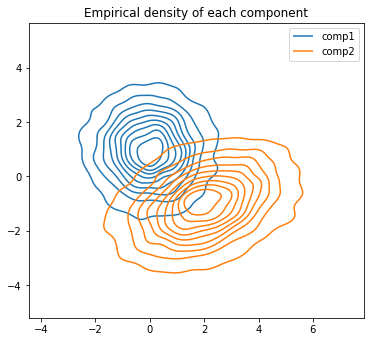

In [ ]:
figh, ax = plt.subplots(1,1,figsize=[6,6])
kdeplot(component_samples[0,:,:], label="comp1", )
kdeplot(component_samples[1,:,:], label="comp2", )
plt.title("Empirical density of each component")
plt.legend()
plt.axis("image");

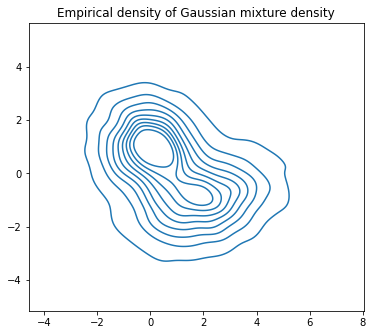

In [ ]:
figh, ax = plt.subplots(1,1,figsize=[6,6])
kdeplot(gmm_samps, )
plt.title("Empirical density of Gaussian mixture density")
plt.axis("image");

Now let's examine the composition of the score vector field to gain some intuition. We'd like to visualize 

* $\nabla \log f_i(x)$
* $w_i\nabla \log f_i(x)$, where $w_i$ is the weights computed from participation $w_i=\pi_i f_i(x)/\sum_j(\pi_j f_j(x))$
* $\nabla p(x)$

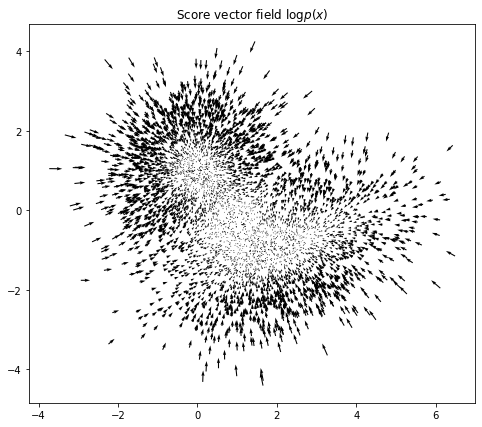

In [ ]:
# score 
plt.figure(figsize=[8,8])
quiver_plot(gmm_samps, scorevecs)
plt.title("Score vector field $\log p(x)$")
plt.axis("image");

In [ ]:
gmm_samps_few, _, _ = gmm.sample(200)
scorevecs_few = gmm.score(gmm_samps_few)
gradvec_list, participance = gmm.score_decompose(gmm_samps_few)

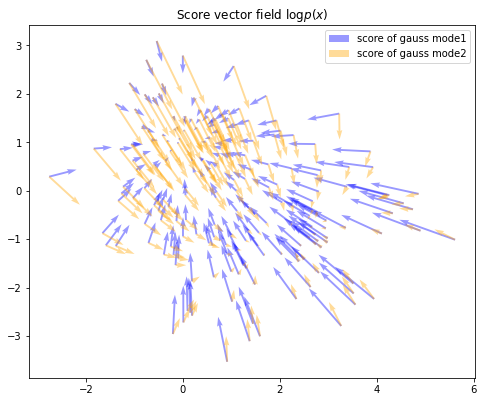

In [ ]:
# score of each Gaussian component
plt.figure(figsize=[8,8])
quiver_plot(gmm_samps_few, gradvec_list[0], color="blue", alpha=0.4, scale=45, label="score of gauss mode1")
quiver_plot(gmm_samps_few, gradvec_list[1], color="orange", alpha=0.4, scale=45, label="score of gauss mode2")
plt.title("Score vector field $\log p(x)$")
plt.axis("image");
plt.legend();

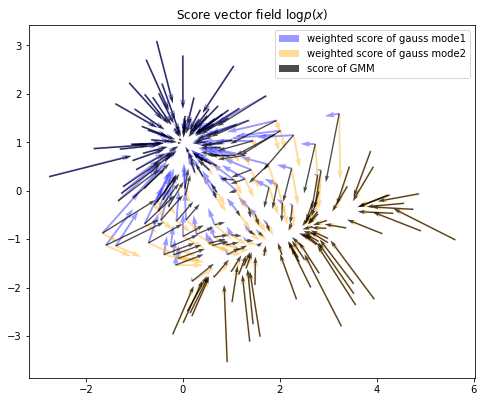

In [ ]:
# score of each Gaussian component weighted by participation
plt.figure(figsize=[8,8])
quiver_plot(gmm_samps_few, gradvec_list[0]*participance[:,0:1], color="blue", alpha=0.4, scale=15, label="weighted score of gauss mode1")
quiver_plot(gmm_samps_few, gradvec_list[1]*participance[:,1:2], color="orange", alpha=0.4, scale=15, label="weighted score of gauss mode2")
quiver_plot(gmm_samps_few, scorevecs_few, scale=15, alpha=0.7, width=0.003, label="score of GMM")
plt.title("Score vector field $\log p(x)$")
plt.axis("image");
plt.legend();

## (Forward) Diffusion process


**Continuous SDE version of diffusion**
$$
d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1]
$$
**Discrete Markov process version of diffusion**
$$
\mathbf{x_{t+\Delta t}} = \mathbf{x_{t}}+\sigma^t \sqrt{\Delta t} z_t
$$
$z_t\sim \mathcal N(0,I)$

The ending distribution of $x(1)$ will be approximately
$$
\mathbf{N}\bigg(\mathbf{x}; \mathbf{0}, \frac{\sigma^2 - 1}{2 \log \sigma}\mathbf{I}\bigg)
$$

### Density during diffusion
More precisely, after $t$ time diffusion, 
$$
p(\mathbf x_t=\mathbf{x}|\mathbf x_0)=\mathcal{N}\bigg(\mathbf{x}; \mathbf x_0, \frac{\sigma^{2t} - 1}{2 \log \sigma}\mathbf{I}\bigg)
$$
We could understand $\mathbf x_t$ as $\mathbf x_0$ plus Gaussian noise, where $\beta_t=\sqrt{\frac{\sigma^{2t} - 1}{2 \log \sigma}}$, the std of the noise. $z\sim \mathcal N(0,I)$
$$
\mathbf x_t=x_0+\beta_t z
$$
For a Gaussian mixture model with $\{\pi_i,\mu_i,\Sigma_i\}$, the exact density $p(\mathbf x_t)$ at time $t$ shall still be a Gaussian Mixture with parameter $\{\pi_i,\mu_i,\Sigma_i^{(t)}\}$, where
$$
\Sigma_i^{(t)}=\Sigma_i+\frac{\sigma^{2t} - 1}{2 \log \sigma}I
$$

We denote the marginal denstiy of $x$ at time $t$, $p_t(\mathbf x)$. 

Using this analytical property, let's define a function `diffuse_gmm` that "time-travel" a `gmm` from $0\to t$

* `marginal_prob_std`, a util function output the standard deviation (std) $\beta_t$ of the conditional distribution $p(x_t|x_0)$. 
* `diffuse_gmm` takes in a `gmm` at $t=0$ and outputs the `gmm` object representing the marginal density at time $t$. 

In [ ]:
def marginal_prob_std(t, sigma):
  """
  pytorch version
  TODO: return the noise std at time t with sigma

  Note, that this std -> 0, when t->0
    So it's not numerically stable to sample t=0 in the dataset
  Note, an earlier version missed the sqrt... 
  """
  raise NotImplementedError
  return ...

def marginal_prob_std_np(t, sigma):
  """
  TODO: return the noise std at time t with sigma
  numpy version
  """
  raise NotImplementedError
  return ...

In [ ]:
def diffuse_gmm(gmm, t, sigma):
  """
  TODO: Finish computing the new `mus`, `covs_dif`, `weights` of the new GMM.
  """
  raise NotImplementedError
  mus = ...
  covs_dif = ...
  weights = ...
  return GaussianMixture(mus, covs_dif, weights)

### Fun time! Diffusion in action

In [ ]:
x0, _, _ = gmm.sample(1000)
sigma = 5
nsteps = 200
x_traj = np.zeros((*x0.shape, nsteps, ))
x_traj[:,:,0] = x0
dt = 1 / nsteps
for i in range(1, nsteps):
  t = i * dt
  eps_z = np.random.randn(*x0.shape)
  """
  TODO: finish the diffusion equaion! 
  """
  raise NotImplementedError
  x_traj[:,:,i] = ...

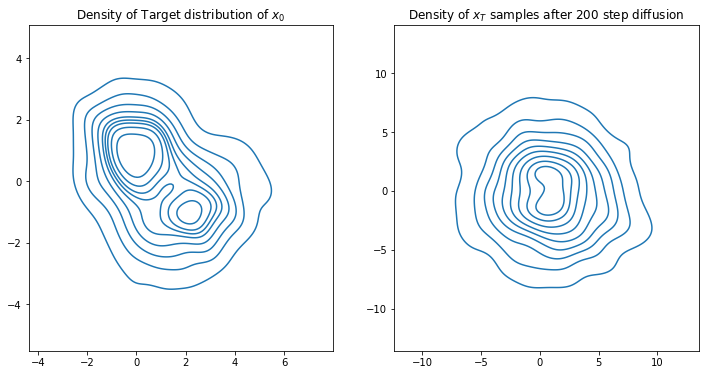

In [ ]:
figh, axs = plt.subplots(1,2,figsize=[12,6])
kdeplot(x_traj[:,:,0], ax=axs[0])
axs[0].set_title("Density of Target distribution of $x_0$")
plt.axis("equal")
kdeplot(x_traj[:,:,-1], ax=axs[1])
axs[1].set_title(f"Density of $x_T$ samples after {nsteps} step diffusion")
plt.axis("equal");

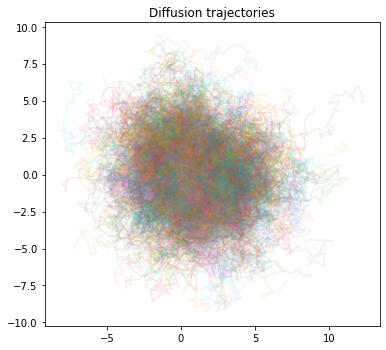

In [ ]:
figh, ax = plt.subplots(1,1,figsize=[6,6])
plt.plot(x_traj[:,0,:].T,x_traj[:,1,:].T,alpha=0.10,)
plt.title("Diffusion trajectories")
plt.axis("image")
plt.show()

### Validate the time dependent density

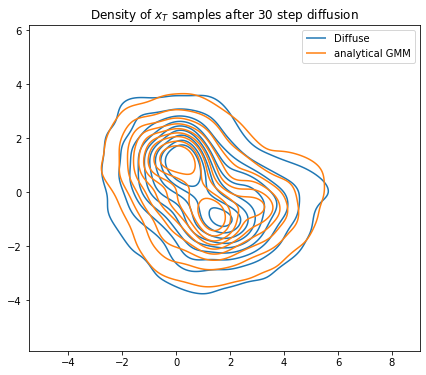

In [ ]:
t_step = 150 #@param {type:"slider", min:0, max:199, step:10}
gmm_t = diffuse_gmm(gmm, t_step / nsteps, sigma)
samps_t, _, _ = gmm_t.sample(2000)

figh, axs = plt.subplots(1,1,figsize=[7,6])
sns.kdeplot(x=x_traj[:,0,t_step], y=x_traj[:,1,t_step], ax=axs, label="Diffuse")
sns.kdeplot(x=samps_t[:,0], y=samps_t[:,1], ax=axs, label="analytical GMM")
axs.set_title(f"Density of $x_T$ samples after {t_step} step diffusion")
plt.axis("equal")
plt.legend()

## Reverse diffusion sampling

**Continuous SDE version**
\begin{align*}
d\mathbf{x} = -\sigma^{2t} \nabla_\mathbf{x} \log p_t(\mathbf{x}) dt + \sigma^t d \bar{\mathbf{w}}.
\end{align*}

$p_t(x)$ is the marginal probability of $x_t$, the diffused density.Let's define the time dependent score function $s(\mathbf{x}_t,t)=\nabla_\mathbf{x}\log p_t(\mathbf{x}_t)$. 

**Discrete Markov chain version**
\begin{align}
\mathbf{x}_{t-\Delta t} = \mathbf{x}_t + \sigma^{2t} s(\mathbf{x}_t,t)\Delta t + \sigma^t\sqrt{\Delta t} \mathbf{z}_t,
\end{align}
where $\mathbf{z}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, 

Now, let's implement the Markov chain version of discrete diffusion. 

In [ ]:
sampN = 1000
sigma = 5
nsteps = 200

lambdaT = (sigma**2 - 1) / (2 * np.log(sigma)) # marginal_prob_std_np(1.0, sigma)
xT = np.sqrt(lambdaT) * np.random.randn(sampN, 2)
x_traj_rev = np.zeros((*x0.shape, nsteps, ))
x_traj_rev[:,:,0] = xT
dt = 1 / nsteps
for i in range(1, nsteps):
  t = (nsteps - i) * dt # note the time fly back
  # transport the gmm to that at time $t$ and compute score at that time $\nabla \log p_t(x)$ 
  score_xt = ...
  """
  TODO: finish the reverse diffusion equaion! 
  """
  raise NotImplementedError
  eps_z = np.random.randn(*x0.shape)
  x_traj_rev[:,:,i] = x_traj_rev[:,:,i-1] + ...

Let's validate the distribution at the end recovers the original GMM

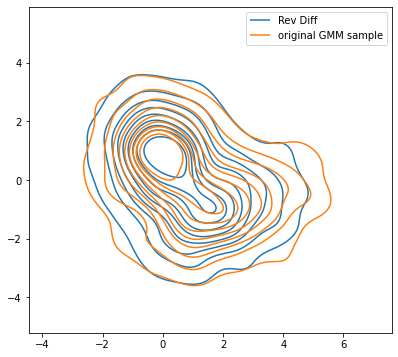

In [ ]:
figh, axs = plt.subplots(1,1,figsize=[6.5, 6])
kdeplot(x_traj_rev[:,:,-1], "Rev Diff", )#ax=axs)
kdeplot(gmm_samps, "original GMM sample", )#ax=axs)
plt.legend()

(-5.4653091881446105,
 8.059743502501288,
 -5.596059107144443,
 4.8413415462330045)

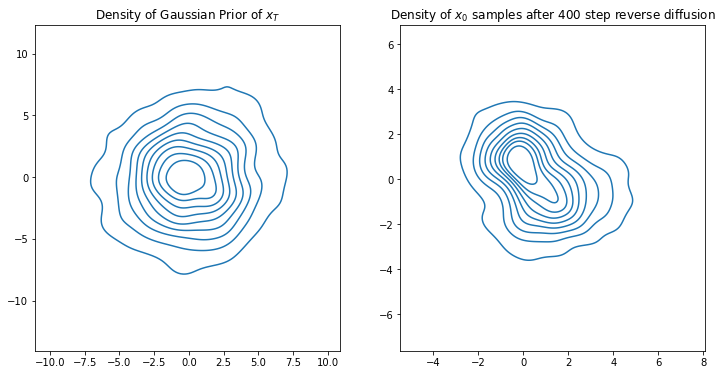

In [ ]:
figh, axs = plt.subplots(1,2,figsize=[12,6])
kdeplot(x_traj_rev[:,:,0], ax=axs[0], titlestr="Density of Gaussian Prior of $x_T$")
plt.axis("equal")
kdeplot(x_traj_rev[:,:,-1], ax=axs[1], titlestr=f"Density of $x_0$ samples after {nsteps} step reverse diffusion")
plt.axis("equal")

### Hint: an incorrect example 

Could you correct this one?

In [ ]:
sampN = 100
sigma = 5
nsteps = 200

lambdaT = (sigma**2 - 1) / (2 * np.log(sigma)) # marginal_prob_std_np(1.0, sigma)
xT = np.sqrt(lambdaT) * np.random.randn(sampN, 2)
x_traj_rev = np.zeros((*x0.shape, nsteps, ))
x_traj_rev[:,:,0] = xT
dt = 1 / nsteps
for i in range(1, nsteps):
  t = i * dt
  eps_z = np.random.randn(*x0.shape)
  score_xt = gmm.score(x_traj_rev[:,:,i-1])
  x_traj_rev[:,:,i] = x_traj_rev[:,:,i-1] + eps_z * (sigma ** t) * np.sqrt(dt) + score_xt * dt * sigma**(2*t)